In [2]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor
from sklearn.metrics import r2_score, mean_squared_error
from sklearn.tree import plot_tree
import joblib


In [3]:
df = pd.read_csv("../data/dataproject2025_preprocessed_combined.csv")
df.head()

,num__annual_inc,num__avg_cur_bal,num__bc_open_to_buy,num__bc_util,num__delinq_2yrs,num__dti,num__emp_length,num__fico_range_high,num__funded_amnt,num__inq_last_6mths,...,label__emp_title,label__home_ownership,label__purpose,ord__grade,ord__sub_grade,passthrough__issue_d,passthrough__zip_code,passthrough__Pct_afro_american,Predicted probabilities,target
0,-0.740512,-0.745082,0.749479,-1.586997,-0.370384,-1.880644,-1.076012,2.106130,-1.180039,1.439967,...,33.0,0.0,3.0,1.0,6.0,2013.0,782.0,7.388592,0.053051,0
1,-0.470965,-0.250508,0.416937,-0.242629,-0.370384,0.530276,1.083330,1.258044,1.180387,-0.694720,...,33.0,1.0,2.0,1.0,6.0,2013.0,481.0,9.745456,0.084507,0
2,4.254853,2.390279,0.248935,0.226833,-0.370384,0.019227,-0.266259,1.766896,1.281169,0.372623,...,41.0,0.0,2.0,0.0,2.0,2013.0,945.0,7.542862,0.037206,0
3,0.841762,1.367198,-0.426078,1.147974,-0.370384,-0.633779,1.083330,0.749193,-0.416216,0.372623,...,33.0,0.0,2.0,1.0,7.0,2013.0,809.0,6.598132,0.061371,0
4,-0.155910,0.630499,-0.342077,0.497129,0.729341,0.561034,0.003659,-0.946979,1.238734,0.372623,...,33.0,0.0,2.0,3.0,19.0,2013.0,802.0,7.058900,0.345896,1


In [4]:
print(df.columns.tolist())

['num__annual_inc', 'num__avg_cur_bal', 'num__bc_open_to_buy', 'num__bc_util', 'num__delinq_2yrs', 'num__dti', 'num__emp_length', 'num__fico_range_high', 'num__funded_amnt', 'num__inq_last_6mths', 'num__int_rate', 'num__mo_sin_old_rev_tl_op', 'num__mo_sin_rcnt_rev_tl_op', 'num__mo_sin_rcnt_tl', 'num__mort_acc', 'num__mths_since_recent_bc', 'num__num_actv_bc_tl', 'num__num_bc_tl', 'num__num_il_tl', 'num__num_rev_accts', 'num__open_acc', 'num__pub_rec', 'num__pub_rec_bankruptcies', 'num__revol_bal', 'num__revol_util', 'num__tax_liens', 'label__emp_title', 'label__home_ownership', 'label__purpose', 'ord__grade', 'ord__sub_grade', 'passthrough__issue_d', 'passthrough__zip_code', 'passthrough__Pct_afro_american', 'Predicted probabilities', 'target']


In [ ]:
# Open the pickle file in read-binary mode
with open("../models/predicted_probabilities.pkl", "rb") as f:
    y = joblib.load(f)

df['predicted'] = y

In [7]:
df["passthrough__issue_d"] = df["passthrough__issue_d"].astype(int)

# Sort by year just in case it's not ordered
df = df.sort_values("passthrough__issue_d").reset_index(drop=True)

In [9]:
X = df.drop(columns = ["target", "Predicted probabilities", 'passthrough__issue_d', 'passthrough__zip_code', 'passthrough__Pct_afro_american', "predicted"])
y = df["predicted"]

In [10]:
train_years = [df["passthrough__issue_d"].min(), df["passthrough__issue_d"].min() + 2]  # first 3 years
val_year = train_years[1] + 1                                 # 4th year
test_year = val_year + 1                                      # 5th year

X_train = X[df["passthrough__issue_d"].between(train_years[0], train_years[1])]
y_train = y[df["passthrough__issue_d"].between(train_years[0], train_years[1])]

X_val = X[df["passthrough__issue_d"] == val_year]
y_val = y[df["passthrough__issue_d"] == val_year]

X_test = X[df["passthrough__issue_d"] == test_year]
y_test = y[df["passthrough__issue_d"] == test_year]

print(f"Train years: {train_years}, Val year: {val_year}, Test year: {test_year}")
print(f"Train size: {len(X_train)}, Val size: {len(X_val)}, Test size: {len(X_test)}")

Train years: [2012, 2014], Val year: 2015, Test year: 2016
Train size: 253015, Val size: 271416, Test size: 258793


# Surrogate models

In [11]:
# Linear regression surrogate
lin_reg = LinearRegression()
lin_reg.fit(X_train, y_train)

# Decision tree surrogate
tree_reg = DecisionTreeRegressor(max_depth=4, random_state=42)
tree_reg.fit(X_train, y_train)

DecisionTreeRegressor(max_depth=4, random_state=42)

# Evaluation of the surrogate models

In [12]:
def evaluate(model, X, y, split_name):
    y_pred = model.predict(X)
    r2 = r2_score(y, y_pred)
    mse = mean_squared_error(y, y_pred)
    print(f"{split_name} - R²: {r2:.4f}, MSE: {mse:.4f}")
    return r2, mse

print("\nLinear Regression Performance:")
evaluate(lin_reg, X_train, y_train, "Train")
evaluate(lin_reg, X_val, y_val, "Validation")
evaluate(lin_reg, X_test, y_test, "Test")

print("\nDecision Tree Performance:")
evaluate(tree_reg, X_train, y_train, "Train")
evaluate(tree_reg, X_val, y_val, "Validation")
evaluate(tree_reg, X_test, y_test, "Test")


Linear Regression Performance:
Train - R²: 0.8610, MSE: 0.0046
Validation - R²: 0.8581, MSE: 0.0051
Test - R²: 0.8334, MSE: 0.0056

Decision Tree Performance:
Train - R²: 0.7797, MSE: 0.0074
Validation - R²: 0.7718, MSE: 0.0082
Test - R²: 0.7305, MSE: 0.0091


(0.7304864499167166, 0.009083635967813985)

All of the $R^2$ values are relatively high for both Linear Regression and Decision Tree surrogate models. Similarly, theur MSE values are relatively low also indicating good performance. However, Linear Regression has better results than Decision Tree with the test $R^2$ value of 0.86 compared to 0.76 and the test MSE of 0.002 compered to 0.003.

# Decision Tree Plot

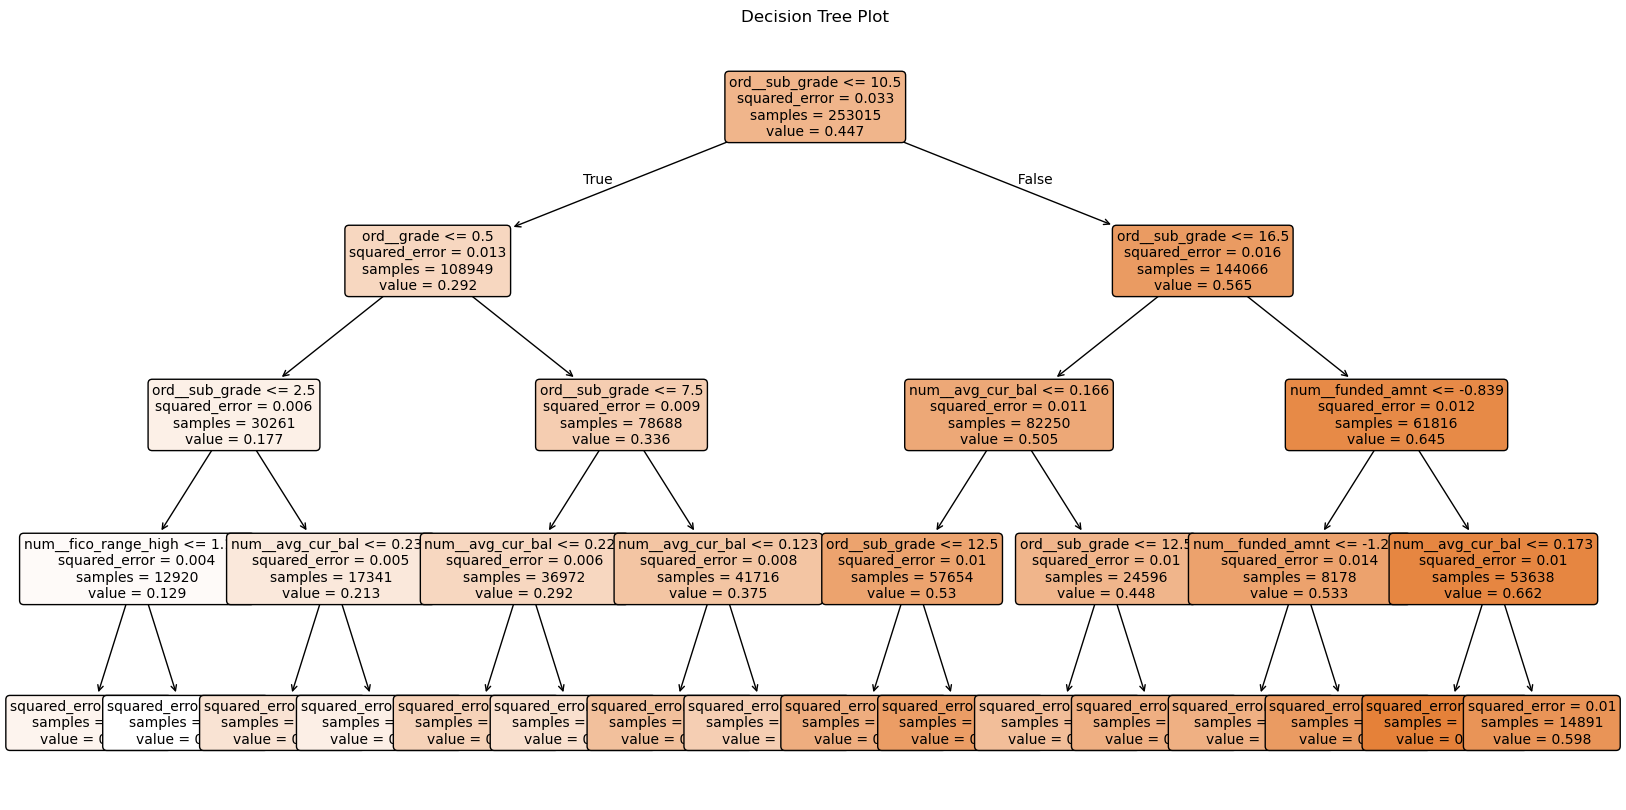

In [13]:
plt.figure(figsize=(20,10))
plot_tree(
    tree_reg,
    feature_names=X.columns,
    filled=True,
    rounded=True,
    fontsize=10
)
plt.title("Decision Tree Plot")
plt.show()

From the decision tree plot we can see that the decision tree surrogate model uses only 3 features: ord__sub_grade, num__avg_cur_bal and num__funded_amnt.

# Comparison of Linear Regression Coefficients and Decision Tree Feature Importances

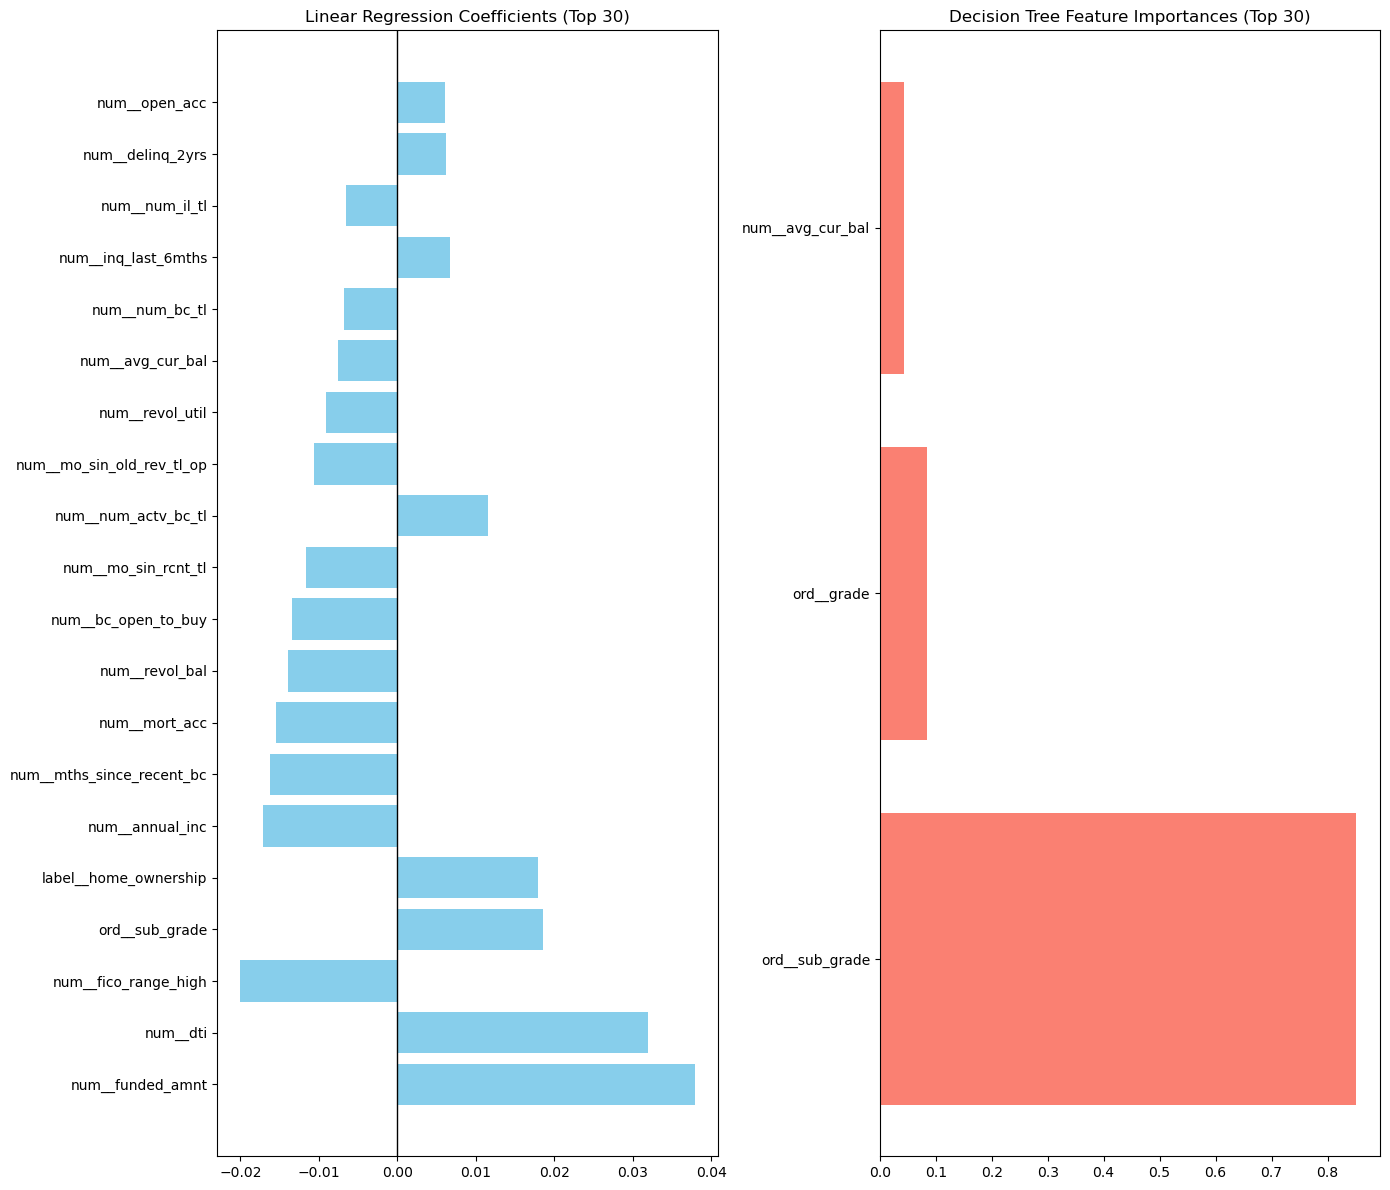

In [14]:


# Collect coefficients from Linear Regression
coef_df = pd.DataFrame({
    "Feature": X.columns,
    "Linear_Coefficient": lin_reg.coef_
})

# Collect importances from Decision Tree
importances_df = pd.DataFrame({
    "Feature": X.columns,
    "Tree_Importance": tree_reg.feature_importances_
})

# Top 20 for Linear Regression
top20_lin = coef_df.reindex(coef_df["Linear_Coefficient"].abs().sort_values(ascending=False).index).head(20)

# Top 20 for Decision Tree
top20_tree = importances_df.sort_values(by="Tree_Importance", ascending=False).head(3)

# Plot separately
fig, axes = plt.subplots(1, 2, figsize=(14, 12))

# Linear Regression Coefficients
axes[0].barh(top20_lin["Feature"], top20_lin["Linear_Coefficient"], color="skyblue")
axes[0].set_title("Linear Regression Coefficients (Top 30)")
axes[0].axvline(0, color="black", linewidth=1)

# Decision Tree Importances
axes[1].barh(top20_tree["Feature"], top20_tree["Tree_Importance"], color="salmon")
axes[1].set_title("Decision Tree Feature Importances (Top 30)")

plt.tight_layout()
plt.show()



Linear Regression uses many coefficiencents with the most prominent ones being: num__int_rate, num__funded_amnt, num__dti, ord__sub_grade and label__home_ownership. Decision Tree uses only 3 features: ord__sub_grade, num__avg_cur_bal and num__funded_amnt with ord__sub_grade being by far the most important one. The results regarding feature importance diverge to an extent, because ord__sub_grade is the most important in the Decision Tree mosel while in the Linear Regression it is only the 4th most important feature, num__avg_cur_bal, which is second in the Decision Tree model doesn't even fit within the first 20 most important features for Linear Regression and num__funded_amnt is third for Decision Tree while being the second for Linear Regression.

# Residual Histograms

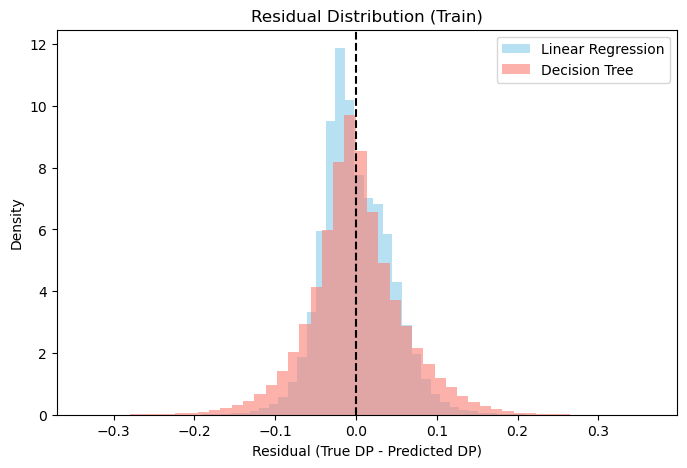

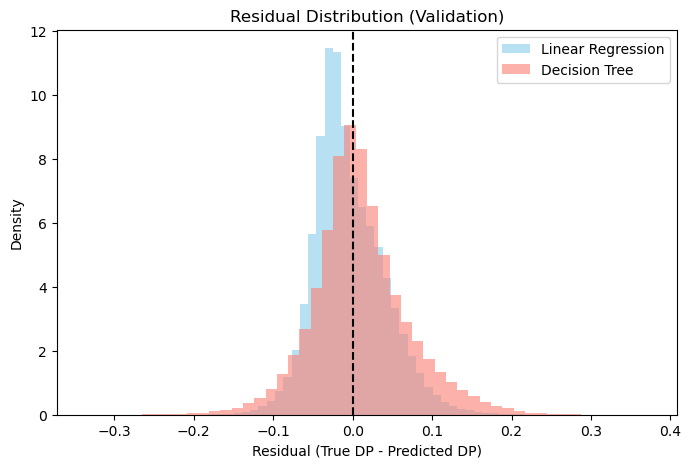

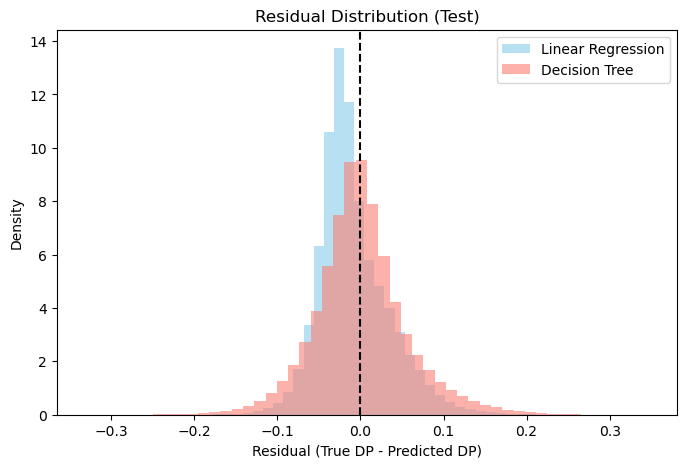

In [ ]:
def plot_residual_histograms(model1, model2, X, y, split_name):
    y_pred1 = model1.predict(X)
    y_pred2 = model2.predict(X)

    lin_residuals = y - y_pred1
    tree_residuals = y - y_pred2

    plt.figure(figsize=(8, 5))
    plt.hist(lin_residuals, bins=50, alpha=0.6, label="Linear Regression", color="skyblue", density=True)
    plt.hist(tree_residuals, bins=50, alpha=0.6, label="Decision Tree", color="salmon", density=True)
    plt.axvline(0, color="black", linestyle="--")
    plt.legend()
    plt.title(f"Residual Distribution ({split_name})")
    plt.xlabel("Residual (True DP - Predicted DP)")
    plt.ylabel("Density")
    plt.show()

# Plot for each split
plot_residual_histograms(lin_reg, tree_reg, X_train, y_train, "Train")
plot_residual_histograms(lin_reg, tree_reg, X_val, y_val, "Validation")
plot_residual_histograms(lin_reg, tree_reg, X_test, y_test, "Test")

